In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math

In [ ]:
# Given a betweenness heuristic, greedily removes nodes from the gcc of G, which is better than considering all of G according to [https://downloads.hindawi.com/journals/complexity/2021/1677445.pdf].
# We consider weights as "cost".
# Halts when the size of the GCC in G is less than C = c * N (c is in (0, 1)).
# Returns S, the set of nodes to remove to dismantle G.
# Does not modify G.
def alg(heuristic, _G, c=0.2):
  start = time.time()

  G = _G.copy()
  N = G.number_of_nodes()
  S = []

  # The connected components are ordered by decreasing size.
  gcc = max(nx.connected_components(G), key=len)
  size_gcc = len(list(gcc))

  while size_gcc > c * N:
    node_to_remove = heuristic(gcc, G)
    G.remove_node(node_to_remove)
    S.append(node_to_remove)

    components = nx.connected_components(G)
    gcc = max(nx.connected_components(G), key=len)
    size_gcc = len(list(gcc))

  print(f"Removed {len(S)} nodes from G.")
  cost = sum(_G.nodes[i]['node weight'] for i in S)
  print(f"Cost: {cost}")
  
  # final_ccs = list(nx.connected_components(G))
  # average_cc_size = sum(len(G) for G in final_ccs) / len(final_ccs)
  # print(f"gcc size: {size_gcc}")
  # print(f"Average cc size: {average_cc_size}")

  end = time.time()
  print(f"Time elapsed: {round(end - start, 3)}s")
  return S, G

# Runs the above algorithm. Colors nodes in S red.
def draw_alg(heuristic, G, c=0.2):
  colors = ["blue" for _ in range(G.number_of_nodes())]
  S, _ = alg(heuristic, G, c)
  for node in S:
    colors[node] = "red"
  nx.draw(G, node_color=colors)

heuristics = [] # Used to keep track of the centralities
heuristics_no_bc = [] # Fast ones only

In [ ]:
def remove_random_node(gcc, G):
  return random.choice(G.nodes())

# heuristics.append(("remove_random_node", remove_random_node))
# heuristics_no_bc.append(("remove_random_node", remove_random_node))

In [ ]:
def remove_lightest_node(gcc, G):
  return min(gcc, key=lambda v: G.nodes[v]['node weight'])

heuristics.append(("remove_lightest_node", remove_lightest_node))
heuristics_no_bc.append(("remove_lightest_node", remove_lightest_node))

In [ ]:
# Removes the node with highest betweenness centrality.
# Not important, but eventual TODO: Implement https://www.researchgate.net/publication/242434858_A_Fast_Algorithm_for_the_Iterative_Calculation_of_Betweenness_Centrality
def betweenness_centrality_wsp(gcc, G):
  # https://www.hindawi.com/journals/complexity/2021/1677445/
  # We find betweenness centrality using weighted shortest paths.
  # The higher the weight of a shortest path, the heavier the nodes are on that path. Thus, disconnecting that path is more better.
  # (Is this true? TODO: Figure out what networkx is doing here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html)
  centrality_dict = nx.betweenness_centrality(G.subgraph(gcc), weight ='edge weight')
  return max(gcc, key=lambda v: centrality_dict[v])

def betweenness_centrality_cd(gcc, G):
  centrality_dict = nx.betweenness_centrality(G.subgraph(gcc), normalized=True)
  return max(gcc, key=lambda v: centrality_dict[v] / G.nodes[v]['node weight'])

heuristics.append(("betweenness_centrality_cd", betweenness_centrality_cd))


def betweenness_centrality_endpoint_weights(gcc, G):
  shortest_paths = nx.shortest_path(G.subgraph(gcc))
  best_vertex, max_centrality = -1, -1
  for v in gcc:
    centrality = 1
    for s in gcc:
      for t in gcc:
        if v in shortest_paths[s][t]:
          centrality += G.nodes[s]['node weight'] 
          centrality += G.nodes[t]['node weight']
    if centrality > max_centrality:
      best_vertex, max_centrality = v, centrality
  return best_vertex

heuristics.append(("betweenness_centrality_endpoint_weights", betweenness_centrality_endpoint_weights))



In [ ]:
# Removes the node with highest betweenness centrality, but only considers log(n) vertices when calculating betweenness centrality.
# k := log(n), and the alg itself, from https://www.worldscientific.com/doi/abs/10.1142/S0218127407018403
def approximate_betweenness_centrality_wsp(gcc, G):
  centrality_dict = nx.betweenness_centrality(G.subgraph(gcc), weight='edge weight', k=max(1, int(np.log(len(gcc)))))
  return max(gcc, key=lambda v: centrality_dict[v])

heuristics.append(("approximate_betweenness_centrality_wsp", approximate_betweenness_centrality_wsp))
heuristics_no_bc.append(("approximate_betweenness_centrality_wsp", approximate_betweenness_centrality_wsp))

def approximate_betweenness_centrality_cd(gcc, G):
  centrality_dict = nx.betweenness_centrality(G.subgraph(gcc), k=max(1, int(np.log(len(gcc)))))
  return max(gcc, key=lambda v: centrality_dict[v] / G.nodes[v]['node weight'])

heuristics.append(("approximate_betweenness_centrality_cd", approximate_betweenness_centrality_cd))
heuristics_no_bc.append(("approximate_betweenness_centrality_cd", approximate_betweenness_centrality_cd))

In [ ]:
def degree_centrality(gcc, G):
  # Page 7, https://computationalsocialnetworks.springeropen.com/articles/10.1186/s40649-020-00081-w
  degrees = nx.degree_centrality(G.subgraph(gcc))
  weighted_degrees = {}
  for u in gcc:
    weighted_degree = 0
    for v in G.neighbors(u):
      weighted_degree += G.nodes[v]['node weight']
    weighted_degrees[u] = weighted_degree
  return max(gcc, key=lambda v: weighted_degrees[v])

heuristics.append(("degree_centrality", degree_centrality))
heuristics_no_bc.append(("degree_centrality", degree_centrality))

In [ ]:
def eigenvector_centrality_cd(gcc, G):
  # Page 7, https://computationalsocialnetworks.springeropen.com/articles/10.1186/s40649-020-00081-w
  # "Eigenvector centrality is a measure where it is still open how to include the efect of node weights."
  centrality_dict = nx.eigenvector_centrality_numpy(G.subgraph(gcc))
  return max(gcc, key=lambda v: centrality_dict[v] / G.nodes[v]['node weight'])

heuristics.append(("eigenvector_centrality_cd", eigenvector_centrality_cd))
heuristics_no_bc.append(("eigenvector_centrality_cd", eigenvector_centrality_cd))

def power_iteration(G, nodelist, max_iter=100):
    A = nx.to_numpy_array(G, nodelist=nodelist, weight='node weight')
    v = np.random.rand(A.shape[1])
    for _ in range(max_iter):
        v = np.dot(A, v)
        try:
          v = v / np.linalg.norm(v)
        except:
          print(_, v)
          x = 5 / 0 
    return v

def eigenvector_centrality_weighted_adj(gcc, G):
  gcc = list(gcc)
  v = power_iteration(G, gcc)
  return gcc[np.argmax(v)]

heuristics.append(("eigenvector_centrality_weighted_adj", eigenvector_centrality_weighted_adj))
heuristics_no_bc.append(("eigenvector_centrality_weighted_adj", eigenvector_centrality_weighted_adj))

def eigenvector_centrality_combined(gcc, G):
  gcc = list(gcc)
  v = power_iteration(G, gcc)
  # I am confused about indexing but I think this makes sense
  cd_v = [u / G.nodes[gcc[i]]['node weight'] for (i, u) in enumerate(v)]
  return max(gcc, key=lambda v: cd_v[gcc.index(v)])

heuristics.append(("eigenvector_centrality_combined", eigenvector_centrality_combined))
heuristics_no_bc.append(("eigenvector_centrality_combined", eigenvector_centrality_combined))

In [ ]:
def simplify_and_invert_laplacian(L):
  L = np.delete(L, 0, axis=0)
  L_tilde = np.delete(L, 0, axis=1)
  L_inv = np.linalg.inv(L_tilde)
  L_with_zeroes_on_top = np.vstack((np.zeros(L_inv.shape[1]), L_inv))
  zeroes_column = np.zeros((L_with_zeroes_on_top.shape[0],1))
  C = np.hstack((zeroes_column, L_with_zeroes_on_top))
  return C

def approx_current_flow_betweenness(gcc, G, using_cd=False, using_weighted_edges=False, using_weighted_supply=False):
  G = G.subgraph(gcc)
  gcc = sorted(list(gcc))
  n = G.number_of_nodes()

  vertices_ordered = {v: i for i, v in enumerate(G.nodes)}
  centrality = {v: 0 for v in G.nodes}

  C = simplify_and_invert_laplacian(nx.laplacian_matrix(G).toarray())

  # k=logn pivots are used for approximation
  for _ in range(int(np.log(n))):
    # Source and sink, chosen uniformly at random
    s, t = random.sample(gcc, k=2)

    # Supply vector b
    b = np.zeros(n)
    b[vertices_ordered[s]] = 1
    b[vertices_ordered[t]] = -1
    if using_weighted_supply: 
      b = b * (G.nodes[s]['node weight'] + G.nodes[t]['node weight'])

    # Potential difference vector p
    p = C @ b

    for v in G.nodes:
      for e in G.edges(v):
        u = e[0] if e[0] != v else e[1]
        direction_of_current = 1 if vertices_ordered[v] < vertices_ordered[u] else -1
        potential_difference = abs(p[vertices_ordered[v]] - p[vertices_ordered[u]])
        centrality[v] += direction_of_current * (G.edges[e]['edge weight'] if using_weighted_edges else 1)


  best_v = max(gcc, key=lambda v: centrality[v] / (G.nodes[v]['node weight'] if using_cd else 1))
  return best_v 

cfbc_cd = lambda gcc, G: approx_current_flow_betweenness(gcc, G, using_cd=True)
cfbc_wedge = lambda gcc, G: approx_current_flow_betweenness(gcc, G, using_weighted_edges=True)
cfbc_wsup = lambda gcc, G: approx_current_flow_betweenness(gcc, G, using_weighted_supply=True)
cfbc_combined = lambda gcc, G: approx_current_flow_betweenness(gcc, G, using_cd=True, using_weighted_edges=True, using_weighted_supply=True)

# Unsure centralities

In [ ]:
# https://link.springer.com/chapter/10.1007/978-3-540-31856-9_44
# Also called 'current flow centrality'.
def information_centrality(gcc, G):
  # TODO: Look into this
  centrality_dict = nx.information_centrality(G.subgraph(gcc), weight='edge weight')
  return max(gcc, key=lambda v: centrality_dict[v])

# TODO: add?

In [ ]:
# https://arxiv.org/abs/0905.4102
def communicability_centrality(gcc, G):
    # Related to the number of walks connecting every pair of nodes, as opposed to the number of shortest paths.
    # TODO: Work with node weights
    centrality_dict = nx.communicability_betweenness_centrality(G.subgraph(gcc))
    return max(gcc, key=lambda v: centrality_dict[v])

# TODO: add?

In [ ]:
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.87.278701
def load_centrality(gcc, G):
    # Related to the fraction of all shortest paths that pass through a node.
    # TODO: Figure out how this is different from betweenness centrality
    centrality_dict = nx.load_centrality(G.subgraph(gcc), weight='edge weight')
    return max(gcc, key=lambda v: centrality_dict[v])

In [ ]:
# https://math.wvu.edu/~cqzhang/Publication-files/my-paper/INS-2012-Laplacian-W.pdf
def laplacian_centrality(gcc, G):
    # Related to the drop in laplacian energy (the sum of the squared eigenvalues of the Laplacian) after removing a vertex.
    # TODO: Figure out how networkx uses weights.
    centrality_dict = nx.laplacian_centrality(G.subgraph(gcc), weight='edge weight')
    return max(gcc, key=lambda v: centrality_dict[v])

In [ ]:
# this is a modified version of laplacian centrality where only the effect on the 
# second eigenvalue of removing a node is considered. ie laplacian energy is 
# redefined as (lambda_2)^2.
def second_eval_estimate(full_G) :

  L = nx.laplacian_matrix(G)
  try :
    v_2 = nx.fiedler_vector(G)
  except :
    return 0
  v_2 = v_2 / np.linalg.norm(v_2)
  return ((L@v_2) @ v_2)**2

def modified_laplacian_centrality(gcc, full_G, CD=False) :
  G = full_G.subgraph(gcc)
  curr_MLE = second_eval_estimate(G) # current modified laplacian energy
  if CD :
    MLCs = [(node, (curr_MLE - second_eval_estimate(G.subgraph(set(G.nodes) - {node})))/G.nodes[node]['node weight']) for node in G.nodes]
  else :
    MLCs = [(node, curr_MLE - second_eval_estimate(G.subgraph(set(G.nodes) - {node}))) for node in G.nodes]
  return max(MLCs, key=lambda x: x[1])[0]

def modified_laplacian_centrality_CD(gcc, full_G) :
  return modified_laplacian_centrality(gcc, full_G, CD=True)

_ = alg(modified_laplacian_centrality_CD, G)
_ = alg(approximate_betweenness_centrality_cd, G)

Removed 48 nodes from G.
Cost: 236
Time elapsed: 4.793s
Removed 36 nodes from G.
Cost: 137
Time elapsed: 0.061s


# Previous tests / debugging

In [ ]:
G = nx.erdos_renyi_graph(75, 0.075)
for n in G.nodes:
  G.nodes[n]['node weight'] = np.random.randint(1,10)

# for u, v in G.edges:
#   G.edges[u,v]['edge weight'] = 1 /( G.nodes[u]['node weight'] + G.nodes[v]['node weight'] )

In [ ]:
_ = alg(laplacian_centrality, G)

Removed 24 nodes from G.
Cost: 114
Time elapsed: 0.584s


In [ ]:
_ = alg(modified_laplacian_centrality_CD, G)

Removed 49 nodes from G.
Cost: 171
Time elapsed: 93.271s


In [ ]:
_ = alg(remove_lightest_node, G)

Removed 48 nodes from G.
Cost: 159
Time elapsed: 0.006s


In [ ]:
_ = alg(betweenness_centrality_wsp, G)

In [ ]:
_ = alg(betweenness_centrality_endpoint_weights, G)

In [ ]:
_ = alg(approximate_betweenness_centrality_wsp, G)

In [ ]:
_ = alg(approximate_betweenness_centrality_cd, G)

Removed 31 nodes from G.
Cost: 118
Time elapsed: 0.041s


In [ ]:
_ = alg(degree_centrality, G)

In [ ]:
_ = alg(eigenvector_centrality_cd, G)

In [ ]:
_ = alg(eigenvector_centrality_weighted_adj, G)

In [ ]:
_ = alg(eigenvector_centrality_combined, G)

In [ ]:
_ = alg(information_centrality, G)

In [ ]:
_ = alg(communicability_centrality, G)

In [ ]:
_ = alg(load_centrality, G)

# More centralities

In [ ]:
G = nx.erdos_renyi_graph(100, 0.05)
for n in G.nodes:
  G.nodes[n]['node weight'] = 1 - random.uniform(0, 1)

for u, v in G.edges:
  G.edges[u,v]['edge weight'] = G.nodes[u]['node weight'] + G.nodes[v]['node weight'] 

def betweenness_centrality_wsp(gcc, G):
  # https://www.hindawi.com/journals/complexity/2021/1677445/
  # We find betweenness centrality using weighted shortest paths.
  # The higher the weight of a shortest path, the heavier the nodes are on that path. Thus, disconnecting that path is more better.
  # (Is this true? TODO: Figure out what networkx is doing here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html)
  centrality_dict = nx.betweenness_centrality(G.subgraph(gcc), weight ='edge weight')
  return max(gcc, key=lambda v: centrality_dict[v])

# _ = alg(betweenness_centrality_wsp, G, c=0.1)
# _ = alg(betweenness_centrality_per_unit_cent, G, c=0.1)

# GND

In [ ]:
# Generate a sea-urchin-sistine-chapel (SUSC) graph
def susc_generator(num_spikes, path_length, p=0):
  
  assert p <= 1
  assert p >= 0

  G = nx.Graph()
  k = 0 # constant to differentiate the two urchins
  
  # Urchin 1
  urchin_1 = 0
  G.add_node(urchin_1)
  k += 1

  for i in range(num_spikes):
    G.add_edge(k, urchin_1) # Add spike to urchin
    k += 1

  # Probabilistically add edges between spikes

  if p > 0:
    for i in range(num_spikes):
      for j in range(num_spikes):
        if i == j:
          continue
        spike_1 = i + 1 + urchin_1
        spike_2 = j + 1 + urchin_1
        if random.uniform(0, 1) <= p:
          G.add_edge(spike_1, spike_2)

  urchin_2 = k
  
  G.add_node(urchin_2)

  k += 1

  # Urchin 2


  for i in range(num_spikes):
    G.add_edge(k, urchin_2) # Add spike to urchin
    k += 1

  if p > 0:
    for i in range(num_spikes):
      for j in range(num_spikes):
        if i == j:
          continue
        spike_1 = i + urchin_2 + 1
        spike_2 = j + urchin_2 + 1
        if random.uniform(0, 1) <= p:
          G.add_edge(spike_1, spike_2)


  # Path

  if path_length == 0:
    G.add_edge(urchin_1, urchin_2)
  else:
    count = G.number_of_nodes() + 1
    start = count

    for i in range(path_length - 1):
      G.add_edge(count, count + 1)
      count += 1
    
    end = count

    G.add_edge(start, urchin_1)
    G.add_edge(end, urchin_2)

  return G

In [ ]:
def assign_weights_randomly(G):
  H = G.copy()
  for n in H.nodes:
    H.nodes[n]['node weight'] = 100 * (1 - random.uniform(0, 1))
  for e in H.edges:
    u, v = e
    H.edges[e]['edge weight'] = H.nodes[u]['node weight'] + H.nodes[v]['node weight']
  return H

In [ ]:
### Generate graphs ###

## Small  ~ 100 nodes
## Medium ~ 500 nodes
## Large  ~ 1000 nodes
# Note that the numbers are not exactly that

# 1. BA graphs

BA_s = nx.barabasi_albert_graph(100, 10)
BA_s_weighted = assign_weights_randomly(BA_s)

BA_m = nx.barabasi_albert_graph(500, 50)
BA_m_weighted = assign_weights_randomly(BA_m)

BA_l = nx.barabasi_albert_graph(1000, 100)
BA_l_weighted = assign_weights_randomly(BA_l)

# 2. Regular graphs

Reg_s = nx.random_regular_graph(10, 100)
Reg_s_weighted = assign_weights_randomly(Reg_s)

Reg_m = nx.random_regular_graph(50, 500)
Reg_m_weighted = assign_weights_randomly(Reg_m)

Reg_l = nx.random_regular_graph(100, 1000)
Reg_l_weighted = assign_weights_randomly(Reg_l)

# 3. ER graphs

ER_s = nx.erdos_renyi_graph(100, 0.1)
ER_s_weighted = assign_weights_randomly(ER_s)

ER_m = nx.erdos_renyi_graph(500, 0.1)
ER_m_weighted = assign_weights_randomly(ER_m)

ER_l = nx.erdos_renyi_graph(1000, 0.1)
ER_l_weighted = assign_weights_randomly(ER_l)

# 4. Lobster

Lobster_s = nx.random_lobster(100, 0.1, 0.1)
Lobster_s_weighted = assign_weights_randomly(Lobster_s)

Lobster_m = nx.random_lobster(500, 0.1, 0.1)
Lobster_m_weighted = assign_weights_randomly(Lobster_m)

Lobster_l = nx.random_lobster(1000, 0.1, 0.1)
Lobster_l_weighted = assign_weights_randomly(Lobster_l)

# 5. Watts-Strogatz

WS_s = nx.watts_strogatz_graph(100, 5, 0.1)
WS_s_weighted = assign_weights_randomly(WS_s)

WS_m = nx.watts_strogatz_graph(500, 5, 0.1)
WS_m_weighted = assign_weights_randomly(WS_s)

WS_l = nx.watts_strogatz_graph(1000, 5, 0.1)
WS_l_weighted = assign_weights_randomly(WS_l)

# 6. SUSC

SUSC_s = susc_generator(100, 3, 0.1)
SUSC_s_weighted = assign_weights_randomly(SUSC_s)

SUSC_m = susc_generator(500, 3, 0.1)
SUSC_m_weighted = assign_weights_randomly(SUSC_m)

SUSC_l = susc_generator(1000, 3, 0.1)
SUSC_l_weighted = assign_weights_randomly(SUSC_l)

# 7. Cycle
C_s = nx.cycle_graph(100)
C_s_weighted = assign_weights_randomly(C_s)

C_m = nx.cycle_graph(500)
C_m_weighted = assign_weights_randomly(C_m)

C_l = nx.cycle_graph(1000)
C_l_weighted = assign_weights_randomly(C_l)

# 8. Grid
G_s = nx.grid_2d_graph(10, 10)
G_s_weighted = assign_weights_randomly(G_s)

G_m = nx.grid_2d_graph(20, 20)
G_m_weighted = assign_weights_randomly(G_m)

G_l = nx.grid_2d_graph(30, 30)
G_l_weighted = assign_weights_randomly(G_l)

# 9. Ladder
L_s = nx.ladder_graph(50)
L_s_weighted = assign_weights_randomly(L_s)

L_m = nx.ladder_graph(250)
L_m_weighted = assign_weights_randomly(L_m)

L_l = nx.ladder_graph(500)
L_l_weighted = assign_weights_randomly(L_l)

# 10. Hypergraph
H_s = nx.hypercube_graph(7)
H_s_weighted = assign_weights_randomly(H_s)

H_m = nx.hypercube_graph(9)
H_m_weighted = assign_weights_randomly(H_m)

H_l = nx.hypercube_graph(10)
H_l_weighted = assign_weights_randomly(H_l)

small_graphs = [
    ("Small BA", BA_s_weighted), 
    ("Small Reg", Reg_s_weighted), 
    ("Small ER", ER_s_weighted), 
    ("Small Lobster", Lobster_s_weighted), 
    ("Small WS", WS_s_weighted), 
    ("Small SUSC", SUSC_s_weighted), 
    ("Small Cycle", C_s_weighted), 
    ("Small Grid", G_s_weighted), 
    ("Small Ladder", L_s_weighted), 
    ("Small Hyper", H_s_weighted)
]

medium_graphs = [
    ("Medium BA", BA_m_weighted), 
    ("Medium Reg", Reg_m_weighted), 
    ("Medium ER", ER_m_weighted), 
    ("Medium Lobster", Lobster_m_weighted), 
    ("Medium WS", WS_m_weighted), 
    ("Medium SUSC", SUSC_m_weighted), 
    ("Medium Cycle", C_m_weighted), 
    ("Medium Grid", G_m_weighted), 
    ("Medium Ladder", L_m_weighted), 
    ("Medium Hyper", H_m_weighted)
]

large_graphs = [
    ("Large BA", BA_l_weighted), 
    ("Large Reg", Reg_l_weighted), 
    ("Large ER", ER_l_weighted), 
    ("Large Lobster", Lobster_l_weighted), 
    ("Large WS", WS_l_weighted), 
    ("Large SUSC", SUSC_l_weighted), 
    ("Large Cycle", C_l_weighted), 
    ("Large Grid", G_l_weighted), 
    ("Large Ladder", L_l_weighted), 
    ("Large Hyper", H_l_weighted)
]

all_graphs = small_graphs + medium_graphs + large_graphs

In [ ]:
def assign_weights_randomly(G):
  H = G.copy()
  for n in H.nodes:
    H.nodes[n]['node weight'] = 100 * (1 - random.uniform(0, 1))
  for e in H.edges:
    H.edges[e]['edge weight'] = 100 * (1 - random.uniform(0, 1))
  return H

def test_heuristics(G, heuristics, timeout=300, name="No name provided", c=0.2, gnd=False):
  results = []
  print("Graph:", name)
  print("n:", G.number_of_nodes(), "m:", G.number_of_edges())
  print("")
  for heuristic in heuristics:
    name = heuristic[0]
    h = heuristic[1]
    print("Testing", name)
    results.append((name, alg(h, G, c, timeout=timeout)))
    print("")

  return results

def test_gnd(G, timeout=300, name="No name provided", c=3):
  results = []
  print("Graph:", name)
  print("n:", G.number_of_nodes(), "m:", G.number_of_edges())
  print("")
  results.append(gnd(G, c, False))
  print("")
  
  return results

def test_graphs(graphs, g_type, heuristics, timeout=300, c=3, gnd=False):
  graph_results = []
  print("--- Running tests for", g_type, "graphs ---")
  print("")
  
  for graph in graphs:
    name = graph[0]
    G = graph[1]
    if gnd:
      graph_results.append(test_gnd(G, timeout, name, c))
    else: 
      graph_results.append(test_heuristics(G, heuristics, timeout, name, c))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("")
  
  print("")
  print("--- All tests for", g_type, "graphs size have now finished ---")
  return graph_results

In [ ]:
### Helper functions ###

# def weighted_vertex_cover(G_star, G, A, A_star, n):
#   n = G.number_of_nodes
#   n_star = G_star.number_of_nodes
#   assert n_star == n
#   S = []
#   d = [sum(A_star[i]) for i in range(n_star)]  
#   w = [sum(A[i]) for i in range(n)]
#   v = [w[i] / d[i] for i in range(n)]
#   E_star = G_star.edges
#   # Loop goes on until there are no more edges in E*
#   while E_star:
#     v_i = v.index(min(v))
#     S.append(v_i)
#     G_star.remove_node(v_i)
#     G.remove_node(v_i)
#   return S



# def get_second_eigenvector(L) : # deprecated, used fiedler_vector function
#   eigenvalue, eigenvectors = np.linalg.eig(L)
#   sorted_evals = sorted(enumerate(eigenvalue), key=lambda x: x[1])
#   print(f"smallest eval: {sorted_evals[0][1]}\n smallest evec: {eigenvectors[sorted_evals[0][0]][:10]}...")
#   v_2 = eigenvectors[sorted_evals[1][0]] # (second-smallest eigenvector)
#   return v_2

def get_second_eigenvector_approx(L_tilde, iters) :
  # draw a v unif random from sphere by drawing each point
  #   as a gaussian and rescaling (as suggested by GND paper)
  v = np.random.normal(0,1, size=L_tilde.shape[0])
  v = v / np.linalg.norm(v, ord=2) # normalize to unit sphere
  v_1 = np.ones(L_tilde.shape[0])
  v = v - (v @ v_1)/(v_1 @ v_1) * v_1 # make v orthogonal to v_1
  # now do iterative approximation for v_2 :
  for _ in range(iters) :
    L_v = L_tilde @ v
    v = L_v / np.linalg.norm(L_v)
  return v


def get_max_degree(G):
  # sorts by degree in descending order, returns first element
  return sorted(G.degree, key=lambda x: x[1], reverse=True)[0]

def draw_graph_with_nodes(G, nodes,node_size=100) :
  for node in G.nodes:
    if node in nodes:
      G.nodes[node]['color'] = 'r'
    else :
      G.nodes[node]['color'] = 'b'
  nx.draw(G, node_color=[G.nodes[v]['color'] for v in G.nodes],node_size=node_size)

def draw_graph_ccs(G,node_size=100) :
  ccs = nx.connected_components(G)
  poss_colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
  pc_ind = 0
  for cc in ccs :
    rand_color = poss_colors[pc_ind]
    for node in cc :
      G.nodes[node]['color'] = rand_color
    pc_ind += 1
    pc_ind %= len(poss_colors)
  nx.draw(G, node_color=[G.nodes[v]['color'] for v in G.nodes],node_size=node_size)

  # node_weights = [gcc.nodes[v]['node weight'] for v in gcc.nodes]

In [ ]:
def nx_wvc_source(G, weight=None) :
  cost = dict(G.nodes(data=weight, default=1))
  # While there are uncovered edges, choose an uncovered and update
  # the cost of the remaining edges.
  cover = set()
  for u, v in G.edges():
    if u in cover or v in cover:
      continue
    if cost[u] <= cost[v]:
      cover.add(u)
      cost[v] -= cost[u]
    else:
      cover.add(v)
      cost[u] -= cost[v]
  return cover

In [ ]:
# GND algorithm

def gnd(G, c, verbose=False):
  G_original = G.copy()
  G = G.copy()
  removed_nodes = set()
  d_max = get_max_degree(G)[1]

  robustness = 0

  ccs = nx.connected_components(G)  
  gcc_node_set = list(max(ccs, key=len))
  gcc_size = len(gcc_node_set)
  gcc = G.subgraph(gcc_node_set).copy()
  # A_gcc = nx.adjacency_matrix(gcc)
  # node_weights = [gcc.nodes[v]['node weight'] for v in gcc.nodes]
  # W_gcc = np.diag(node_weights)
  if verbose :
    iter_tracker = 1

  while gcc_size > c:
    if verbose: 
      print(f"--- Starting iter {iter_tracker}")
    # Setup
    # n = gcc.number_of_nodes()
    # B = A_gcc @ W_gcc + W_gcc @ A_gcc - A_gcc
    # D_B = np.diag([sum(B[i]) for i in range(n)])
    # L_w = D_B - B
    # d_max = get_max_degree(gcc)[1]
    # L_tilde = 6 * d_max**2 * np.eye(n) - L_w

    v_2_fiedler = nx.fiedler_vector(gcc, weight='edge weight')
    v_2_rounded = np.sign(v_2_fiedler)
    nodes_in_M = [gcc_node_set[i] for i in range(len(v_2_rounded)) if v_2_rounded[i] >= 0]

    # plt.title(f"G at end of iteration: {iter_tracker}")
    # draw_graph_with_nodes(G, nodes_in_M)
    # plt.figure()

    edges_across_cut = []
    for u, v in gcc.edges:
      if (u in nodes_in_M) != (v in nodes_in_M):
        edges_across_cut.append((u, v))

    #assert len(edges_across_cut) > 0

    # compute optimal cut
    G_star = gcc.edge_subgraph(edges_across_cut).copy()
    S = nx_wvc_source(G_star, weight='node weight')
    removed_nodes.update(S)

    robustness += (gcc_size - len(S)) * sum(G.nodes[v]['node weight'] for v in S)

    # Updates
    G.remove_nodes_from(list(S))
    ccs = nx.connected_components(G) 
    gcc_node_set = list(max(ccs, key=len))
    gcc_size = len(gcc_node_set)
    gcc = G.subgraph(gcc_node_set).copy()
    # A_gcc = nx.adjacency_matrix(gcc)
    # node_weights = [gcc.nodes[v]['node weight'] for v in gcc.nodes]
    # W_gcc = np.diag(node_weights)
    
    if verbose:
      # plt.title(f"G at end of iteration: {iter_tracker}")
      # draw_graph_with_nodes(G_original, nodes_in_M)
      # plt.figure()
      print(f"--- Ending iter {iter_tracker}")
      # print(nodes_in_M)
      print(edges_across_cut)
      print(len(S))
      # print(gcc_size)
      iter_tracker += 1

  # # reinsertion greedily:
  # while gcc_size <= c :
  print(f"Robustness: {robustness / G_original.number_of_nodes()}")

  return removed_nodes

In [ ]:
### Run GND on all graphs ###

results_gnd = test_graphs(all_graphs, "all", [gnd], timeout=300, c=3, gnd=True)

--- Running tests for all graphs ---

Graph: Small BA
n: 100 m: 900

Robustness: 1737.2048525908708

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small Reg
n: 100 m: 500

Robustness: 1045.4769372846881

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small ER
n: 100 m: 516

Robustness: 1368.7850231137531

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small Lobster
n: 12 m: 11

Robustness: 48.65376786690769

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small WS
n: 100 m: 200

Robustness: 528.3087135437399

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small SUSC
n: 205 m: 2089

Robustness: 1614.6131290622277

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small Cycle
n: 100 m: 100

Robustness: 178.62406630626654

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small Grid
n: 100 m: 180

Robustness: 774.6592936476222

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small Ladder
n: 100 m: 148

Robustness: 313.31482000331357

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Small Hyper
n: 128 m: 448

Robustness: 1303.4981124537112

~~~~~~~~~~~~~~~~~~~~~~~~~~~

Graph: Medium BA
n: 500 m:

In [ ]:
RG = nx.erdos_renyi_graph(100, 0.1)
# G = susc_generator(20, 2, p=0)
# G = nx.random_lobster(200, 0.15, 0.15)
for n in G.nodes:
  G.nodes[n]['node weight'] = 100 * (1 - random.randrange(0, 1))

for e in G.edges:
  u, v = e
  G.edges[e]['edge weight'] = G.nodes[u]['node weight'] + G.nodes[v]['node weight']

In [ ]:
_ = alg(eigenvector_centrality_cd, G, c=1/100)

TypeError: ignored

Number of nodes removed: 143
Nodes removed: {256, 1, 257, 3, 258, 259, 5, 6, 7, 9, 10, 11, 8, 263, 264, 267, 13, 14, 18, 270, 271, 21, 17, 279, 275, 25, 26, 27, 28, 29, 277, 23, 280, 282, 34, 35, 291, 33, 292, 39, 295, 41, 42, 297, 262, 36, 38, 48, 51, 52, 53, 54, 2, 12, 62, 64, 66, 67, 68, 69, 72, 73, 74, 75, 76, 78, 80, 81, 83, 88, 272, 90, 91, 93, 19, 98, 274, 100, 101, 102, 104, 4, 107, 112, 114, 116, 118, 121, 123, 126, 128, 129, 132, 133, 134, 281, 136, 137, 139, 140, 260, 147, 284, 151, 30, 153, 155, 157, 160, 162, 163, 165, 169, 170, 172, 179, 180, 183, 189, 190, 191, 193, 194, 199, 202, 205, 207, 208, 213, 214, 215, 218, 219, 222, 241, 242, 243, 244, 245, 248, 251, 253, 254}
------------
Removed 120 nodes from G.
Cost: 120
Time elapsed: 1.763s
Nodes removed: [264, 114, 245, 213, 108, 16, 98, 155, 18, 205, 133, 88, 37, 103, 219, 75, 26, 274, 216, 5, 193, 90, 125, 207, 36, 122, 129, 137, 170, 260, 162, 166, 28, 269, 123, 209, 82, 169, 182, 134, 53, 135, 150, 139, 89, 24, 119, 10

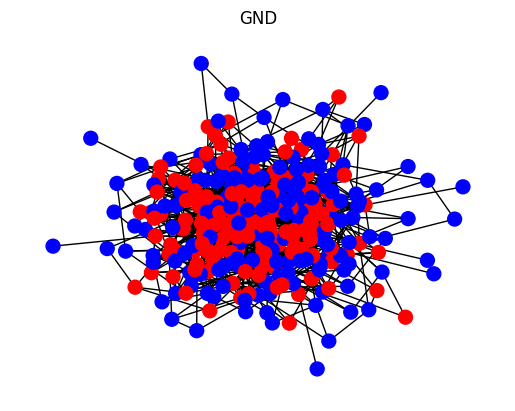

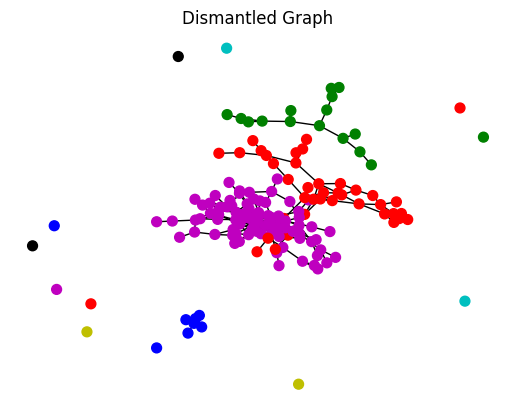

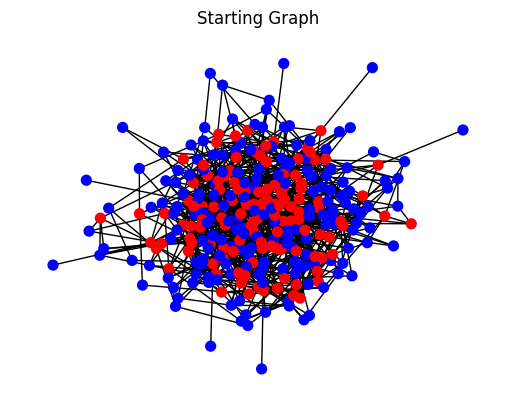

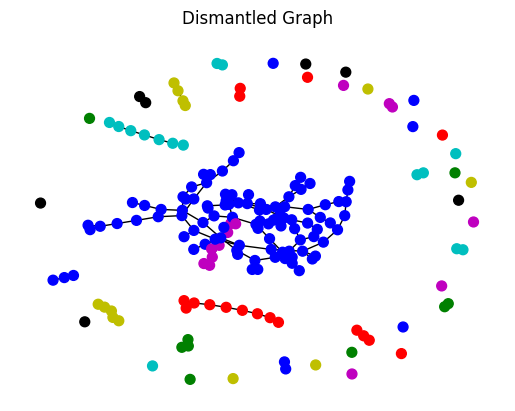

In [ ]:
C = 100
node_size=50
S = gnd(G, C, verbose=False)

print(f"Number of nodes removed: {len(S)}")
print(f"Nodes removed: {S}")
plt.title(f"GND")
draw_graph_with_nodes(G, S)
plt.figure()
plt.title(f"Dismantled Graph")
g_c2 = G.copy()
g_c2.remove_nodes_from(S)
draw_graph_ccs(g_c2,node_size=node_size)
plt.figure()
print(f"------------")
S_ab, _ = alg(approximate_betweenness_centrality_cd, G, c=C / G.number_of_nodes())
print(f"Nodes removed: {S_ab}")
plt.title(f"Starting Graph")
draw_graph_with_nodes(G, S_ab,node_size=node_size)
plt.figure()
plt.title(f"Dismantled Graph")
g_c2 = G.copy()
g_c2.remove_nodes_from(S_ab)
draw_graph_ccs(g_c2,node_size=node_size)

More centralities:
* https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012200

# Testing

In [ ]:
def assign_weights_randomly(G):
  H = G.copy()
  for n in H.nodes:
    H.nodes[n]['node weight'] = np.random.randint(1,10)
  return H

def test_heuristics(G, heuristics, name="No name provided", c=0.2, verbose=False):
  results = []
  print("Graph:", name)
  print("n:", G.number_of_nodes(), "m:", G.number_of_edges())
  print("")
  for heuristic in heuristics:
    name = heuristic[0]
    h = heuristic[1]
    print("Testing", name)
    results.append((name, alg(h, G, c)))
    print("")
  # Test GND separately
  #print("Testing GND")
  #print("")
  #results.append(("GND", gnd(G, c)))
  return results

def draw_results(results):
  for result in results:
    name = result[0]
    S, graph = result[1]
    print("Results for", name)
    print("Set S of removed vertices:", S)
    print("Resulting graph, G':")
    nx.draw(graph)

In [ ]:
### Graph generation ###
BA_s = nx.barabasi_albert_graph(100, 10)
BA_s_weighted = assign_weights_randomly(BA_s)

BA_l = nx.barabasi_albert_graph(500, 50)
BA_l_weighted = assign_weights_randomly(BA_l)

Reg_s = nx.random_regular_graph(10, 100)
Reg_s_weighted = assign_weights_randomly(Reg_s)

Reg_l = nx.random_regular_graph(50, 500)
Reg_l_weighted = assign_weights_randomly(Reg_l)

ER_s = nx.erdos_renyi_graph(100, 0.1)
ER_s_weighted = assign_weights_randomly(ER_s)

ER_l = nx.erdos_renyi_graph(500, 0.1)
ER_l_weighted = assign_weights_randomly(ER_l)


Lobster_s = nx.random_lobster(100, 0.1, 0.1)
Lobster_s_weighted = assign_weights_randomly(Lobster_s)

Lobster_l = nx.random_lobster(500, 0.1, 0.1)
Lobster_l_weighted = assign_weights_randomly(Lobster_l)

WS_s = nx.watts_strogatz_graph(100, 5, 0.1)
WS_s_weighted = assign_weights_randomly(WS_s)

WS_l = nx.watts_strogatz_graph(100, 5, 0.1)
WS_l_weighted = assign_weights_randomly(WS_l)


Barbell_s = nx.barbell_graph(100, 1)
Barbell_s_weighted = assign_weights_randomly(Barbell_s)

Barbell_l = nx.barbell_graph(500, 5)
Barbell_l_weighted = assign_weights_randomly(Barbell_l)


NameError: ignored

In [ ]:
## Testing small ER graph ##
results_ER_s = test_heuristics(ER_s_weighted, heuristics, "Small ER")

Graph: Small ER
n: 100 m: 457

Testing remove_lightest_node
Removed 76 nodes from G.
Cost: 341
Time elapsed: 0.072s

Testing betweenness_centrality_cd
Removed 57 nodes from G.
Cost: 257
Time elapsed: 2.578s

Testing betweenness_centrality_endpoint_weights
Removed 50 nodes from G.
Cost: 286
Time elapsed: 5.807s

Testing approximate_betweenness_centrality_wsp
Removed 56 nodes from G.
Cost: 300
Time elapsed: 0.237s

Testing approximate_betweenness_centrality_cd
Removed 60 nodes from G.
Cost: 282
Time elapsed: 0.15s

Testing degree_centrality
Removed 52 nodes from G.
Cost: 262
Time elapsed: 0.05s

Testing eigenvector_centrality_cd
Removed 62 nodes from G.
Cost: 265
Time elapsed: 0.27s

Testing eigenvector_centrality_weighted_adj
Removed 53 nodes from G.
Cost: 296
Time elapsed: 0.199s

Testing eigenvector_centrality_cd
Removed 62 nodes from G.
Cost: 265
Time elapsed: 0.184s



In [ ]:
## Testing large ER graph ##
results_ER_l = test_heuristics(ER_l_weighted, heuristics_no_bc, "Large ER")

Graph: Large ER
n: 500 m: 12342

Testing remove_lightest_node
Removed 400 nodes from G.
Cost: 1685
Time elapsed: 0.32s

Testing approximate_betweenness_centrality_wsp
Removed 398 nodes from G.
Cost: 2032
Time elapsed: 43.01s

Testing approximate_betweenness_centrality_cd
Removed 398 nodes from G.
Cost: 1794
Time elapsed: 17.678s

Testing degree_centrality
Removed 399 nodes from G.
Cost: 1902
Time elapsed: 3.651s

Testing eigenvector_centrality_cd
Removed 400 nodes from G.
Cost: 1746
Time elapsed: 18.161s

Testing eigenvector_centrality_weighted_adj
Removed 400 nodes from G.
Cost: 2040
Time elapsed: 6.251s

Testing eigenvector_centrality_cd
Removed 400 nodes from G.
Cost: 1746
Time elapsed: 9.05s



In [ ]:
## Testing small lobster graph ##
results_Lobster_s = test_heuristics(Lobster_s_weighted, heuristics, "Small Lobster")

Graph: Small Lobster
n: 74 m: 73

Testing remove_lightest_node
Removed 11 nodes from G.
Cost: 15
Time elapsed: 0.002s

Testing betweenness_centrality_cd
Removed 5 nodes from G.
Cost: 8
Time elapsed: 0.104s

Testing betweenness_centrality_endpoint_weights
Removed 7 nodes from G.
Cost: 47
Time elapsed: 0.529s

Testing approximate_betweenness_centrality_wsp
Removed 5 nodes from G.
Cost: 34
Time elapsed: 0.008s

Testing approximate_betweenness_centrality_cd
Removed 5 nodes from G.
Cost: 8
Time elapsed: 0.007s

Testing degree_centrality
Removed 6 nodes from G.
Cost: 21
Time elapsed: 0.004s

Testing eigenvector_centrality_cd
Removed 7 nodes from G.
Cost: 17
Time elapsed: 0.03s

Testing eigenvector_centrality_weighted_adj
Removed 6 nodes from G.
Cost: 42
Time elapsed: 0.009s

Testing eigenvector_centrality_cd
Removed 7 nodes from G.
Cost: 17
Time elapsed: 0.012s



In [ ]:
## Testing large lobster graph ##
results_Lobster_l = test_heuristics(Lobster_l_weighted, heuristics_no_bc, "Large Lobster")

Graph: Large Lobster
n: 1004 m: 1003

Testing remove_lightest_node
Removed 82 nodes from G.
Cost: 82
Time elapsed: 0.114s

Testing approximate_betweenness_centrality_wsp
Removed 7 nodes from G.
Cost: 36
Time elapsed: 0.182s

Testing approximate_betweenness_centrality_cd
Removed 6 nodes from G.
Cost: 6
Time elapsed: 0.112s

Testing degree_centrality
Removed 10 nodes from G.
Cost: 50
Time elapsed: 0.059s

Testing eigenvector_centrality_cd
Removed 18 nodes from G.
Cost: 30
Time elapsed: 0.539s

Testing eigenvector_centrality_weighted_adj
Removed 11 nodes from G.
Cost: 48
Time elapsed: 0.272s

Testing eigenvector_centrality_cd
Removed 16 nodes from G.
Cost: 23
Time elapsed: 0.572s



In [ ]:
## Testing small Watts-Strogatz graph ##
results_WS_s = test_heuristics(WS_s_weighted, heuristics, "Small Watts-Strogatz")

Graph: Small Watts-Strogatz
n: 100 m: 200

Testing remove_lightest_node
Removed 54 nodes from G.
Cost: 172
Time elapsed: 0.019s

Testing betweenness_centrality_cd
Removed 24 nodes from G.
Cost: 66
Time elapsed: 0.949s

Testing betweenness_centrality_endpoint_weights
Removed 15 nodes from G.
Cost: 73
Time elapsed: 2.27s

Testing approximate_betweenness_centrality_wsp
Removed 19 nodes from G.
Cost: 97
Time elapsed: 0.077s

Testing approximate_betweenness_centrality_cd
Removed 21 nodes from G.
Cost: 60
Time elapsed: 0.047s

Testing degree_centrality
Removed 37 nodes from G.
Cost: 147
Time elapsed: 0.025s

Testing eigenvector_centrality_cd
Removed 35 nodes from G.
Cost: 97
Time elapsed: 0.267s

Testing eigenvector_centrality_weighted_adj
Removed 30 nodes from G.
Cost: 156
Time elapsed: 0.127s

Testing eigenvector_centrality_cd
Removed 35 nodes from G.
Cost: 97
Time elapsed: 0.185s



In [ ]:
## Testing large Watts-Strogatz graph ##
results_WS_l = test_heuristics(WS_l_weighted, heuristics_no_bc, "Large Watts-Strogatz")

Graph: Large Watts-Strogatz
n: 100 m: 200

Testing remove_lightest_node
Removed 43 nodes from G.
Cost: 109
Time elapsed: 0.024s

Testing approximate_betweenness_centrality_wsp
Removed 24 nodes from G.
Cost: 110
Time elapsed: 0.159s

Testing approximate_betweenness_centrality_cd
Removed 29 nodes from G.
Cost: 71
Time elapsed: 0.1s

Testing degree_centrality
Removed 30 nodes from G.
Cost: 114
Time elapsed: 0.044s

Testing eigenvector_centrality_cd
Removed 42 nodes from G.
Cost: 122
Time elapsed: 0.409s

Testing eigenvector_centrality_weighted_adj
Removed 30 nodes from G.
Cost: 169
Time elapsed: 0.175s

Testing eigenvector_centrality_cd
Removed 40 nodes from G.
Cost: 111
Time elapsed: 0.206s



In [ ]:
## Testing small Barbell graph ##
results_Barbell_s = test_heuristics(Barbell_s_weighted, heuristics, "Small Barbell")

Graph: Small Barbell
n: 201 m: 9902

Testing remove_lightest_node
Removed 121 nodes from G.
Cost: 415
Time elapsed: 0.121s

Testing betweenness_centrality_cd
Removed 120 nodes from G.
Cost: 617
Time elapsed: 32.221s

Testing betweenness_centrality_endpoint_weights
Removed 120 nodes from G.
Cost: 826
Time elapsed: 36.42s

Testing approximate_betweenness_centrality_wsp
Removed 120 nodes from G.
Cost: 617
Time elapsed: 3.785s

Testing approximate_betweenness_centrality_cd
Removed 120 nodes from G.
Cost: 617
Time elapsed: 1.474s

Testing degree_centrality
Removed 120 nodes from G.
Cost: 413
Time elapsed: 0.576s

Testing eigenvector_centrality_cd
Removed 121 nodes from G.
Cost: 417
Time elapsed: 3.786s

Testing eigenvector_centrality_weighted_adj
Removed 120 nodes from G.
Cost: 640
Time elapsed: 2.437s

Testing eigenvector_centrality_cd
Removed 121 nodes from G.
Cost: 417
Time elapsed: 1.895s



In [ ]:
## Testing large Barbell graph ##
results_Barbell_l = test_heuristics(Barbell_l_weighted, heuristics_no_bc, "Large Barbell")

Graph: Large Barbell
n: 1005 m: 249506

Testing remove_lightest_node
Removed 603 nodes from G.
Cost: 1987
Time elapsed: 5.393s

Testing approximate_betweenness_centrality_wsp
Removed 599 nodes from G.
Cost: 2988
Time elapsed: 741.925s

Testing approximate_betweenness_centrality_cd


In [ ]:
## Testing small Barabási-Albert graph ##
results_BA_s = test_heuristics(BA_s_weighted, heuristics, "Small Barabási-Albert")

In [ ]:
## Testing large Barabási-Albert graph ##
results_BA_l = test_heuristics(BA_l_weighted, heuristics_no_bc, "Large Barabási-Albert")

In [ ]:
## Testing small regular graph ##
results_Reg_s = test_heuristics(Reg_s_weighted, heuristics, "Small Regular")

In [ ]:
## Testing large regular graph ##
results_Reg_l = test_heuristics(Reg_l_weighted, heuristics_no_bc, "Large Regular")

In [ ]:
# Generate a sea-urchin-sistine-chapel (SUSC) graph
def susc_generator(num_spikes, path_length, p=0):
  
  assert p <= 1
  assert p >= 0

  G = nx.Graph()
  k = 0 # constant to differentiate the two urchins
  
  # Urchin 1
  urchin_1 = 0
  G.add_node(urchin_1)
  k += 1

  for i in range(num_spikes):
    G.add_edge(k, urchin_1) # Add spike to urchin
    k += 1

  # Probabilistically add edges between spikes

  if p > 0:
    for i in range(num_spikes):
      for j in range(num_spikes):
        if i == j:
          continue
        spike_1 = i + 1 + urchin_1
        spike_2 = j + 1 + urchin_1
        if random.uniform(0, 1) <= p:
          G.add_edge(spike_1, spike_2)


  urchin_2 = k
  
  G.add_node(urchin_2)

  k += 1

  # Urchin 2


  for i in range(num_spikes):
    G.add_edge(k, urchin_2) # Add spike to urchin
    k += 1

  if p > 0:
    for i in range(num_spikes):
      for j in range(num_spikes):
        if i == j:
          continue
        spike_1 = i + urchin_2 + 1
        spike_2 = j + urchin_2 + 1
        if random.uniform(0, 1) <= p:
          G.add_edge(spike_1, spike_2)


  # Path

  if path_length == 0:
    G.add_edge(urchin_1, urchin_2)
  else:
    count = G.number_of_nodes() + 1
    start = count

    for i in range(path_length - 1):
      G.add_edge(count, count + 1)
      count += 1
    
    end = count

    G.add_edge(start, urchin_1)
    G.add_edge(end, urchin_2)

  return G